# Hamiltonian simulation via Trotter decomposition
One of the most sought-after applications of quantum computing is the simulation of physical processes, e.g., simulating molecules for drug development and many-body problems. These simulations generally involve taking a Hamiltonian operator $\hat H$ and a time $t$ which is used to evolve an arbitrary state from $|\psi\rangle$ to $e^{i\hat H t}|\psi\rangle$. Creating a circuit that applies the operator $e^{i \hat H t}$ is not immediately obvious, but we can start off with a two-qubit example. 

**Simulating $\sigma_i$ exponentials**

Suppose we want to simulate $e^{i \sigma_z \otimes \sigma_z t}$. The circuit to do this is known to be [[1]](https://quantumcomputing.stackexchange.com/a/11373/16092):

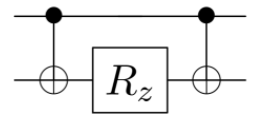

where the argument to the rotation gate $R_z$ is $-2t$. 

Showing that this circuit is equivalent to $e^{i \sigma_z \otimes \sigma_z t}$ is not too hard. Remember that we have the Euler-like decomposition of the operator as $e^{i \sigma_z \otimes \sigma_z t} = \cos(t) I+ i \sin(t) \sigma_z \otimes \sigma_z$ (which works since we have that $\sigma_z^2 = I$). Thus, we have to show that the circuit above simplifies to this same expression. Doing this is a bit long but not hard, as shown below:

$$
\begin{align}
\text{CNOT}(I \otimes e^{i \sigma_zt})\text{CNOT} &= \text{CNOT}\big[ \cos(t) I\otimes I + i \sin(t) I \otimes \sigma_z \big]\big[|0\rangle \langle 0 | \otimes I + |1\rangle \langle 1 | \otimes \sigma_x \big] \\
&=\text{CNOT}\big[ \cos(t)|0\rangle\langle0|\otimes I+\cos(t)|1\rangle\langle1| \otimes \sigma_x + i\sin(t)|0\rangle\langle0|\otimes\sigma_z+ i\sin(t)|1\rangle\langle1|\otimes\sigma_z\sigma_x \big] \\
&= \cos(t)|0\rangle\langle0|\otimes I + \cos(t)|1\rangle\langle1|\otimes I + i\sin(t)|0\rangle\langle0|\otimes\sigma_z+i\sin(t)|1\rangle\langle1|\otimes\sigma_x\sigma_z\sigma_x \\
&= \cos(t) I+i \sin(t)\big[|0\rangle\langle0|\otimes\sigma_z-|1\rangle\langle1|\otimes\sigma_z\big] \qquad (\text{since }\sigma_x\sigma_z\sigma_x=-\sigma_z) \\
&= \cos(t) I+i \sin(t)\big[(|0\rangle\langle0| - |1\rangle\langle1|) \otimes\sigma_z\big] \\
&= \cos(t) I + i \sin(t) \sigma_z \otimes \sigma_z \qquad (\text{since } \sigma_z = |0\rangle\langle0| - |1\rangle\langle1|)
\end{align}
$$

This can easily be extended to any number of qubits, i.e., $e^{i \sigma_z \otimes \sigma_z \otimes \cdots \otimes \sigma_z t}$ [[3]](https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441). Now, what happens if we have a Pauli matrix that is not $\sigma_z$ in the exponent? Well, just apply a self-inverse gate $U$ before and after the chain of $CX$s such that $\sigma_k = U\sigma_zU$, where $k \in \{x, y\}$. This gate would be the Hadamard gate for $\sigma_x$ and $\frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i \\ i & -1 \end{bmatrix}$ for $\sigma_y$. And if its the identity, you can just leave that qubit unaffected!

**Simulating general exponentials**

But this just tells us how to simulate Pauli strings, and we may not be given the Hamiltonian $\hat H$ on this form. However, it is a fact that for any matrix $A$ with its dimension being a power of $2$ (which would be the case here since we are working with qubits), there exists some decomposition into a Pauli string of the following form [[2]](https://quantumcomputing.stackexchange.com/a/8726/16092):

$$ A =\sum_{i,j,k,l}h_{ijkl}\cdot \frac{1}{4}\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l $$
where
$$ h_{ijkl} = \frac{1}{4}\text{Tr}\big((\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes\sigma_l) \cdot A\big) $$

Thus, knowing how to simulate Pauli strings, we can basically simulate any Hamiltonian $H$. Using the Pauli string of a Hamiltonian, we can construct the Trotter decomposition for which we can create a circuit based off the simple circuit we saw above. The Trotter decomposition looks as follows:

$$e^{i\hat Ht} \approx \big(\prod_k e^{i c_k P_k t/N }\big)^{N},$$

where $P_k$ is a tensor product of Pauli matrices, $c_k$ the coefficient corresponding to each $P_k$, $t$ the time introduced at the beggining, and $N$ a number called the Trotter number. The bigger $N$ is, the more accurate our simulation is. The specifics of Trotter decomposition are out of the scope of this brief notebook, but a good start is chapter 4.1 of [[3]](https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441).

**Qiskit implementation**

With this background in place, we can start implementing the simulation in Qiskit. First we are going to define a simple function that creates the circuit scheme introduced at the beggining for operators of the form $e^{i \sigma_z \otimes \sigma_z \otimes \cdots \otimes \sigma_z t}$.

In [2]:
from qiskit import QuantumCircuit
import numpy as np

def sim_z(t, qc, qubits):
    """
    Add gates to simulate a Pauli Z string exponential
   
    Parameters:
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
    """
    for i in range(len(qubits) - 1):
        qc.cx(qubits[i], qubits[i + 1])
    qc.rz(-2 * t, qubits[-1])
    for i in range(len(qubits) - 1, 0, -1):
        qc.cx(qubits[i - 1], qubits[i])

Using this, we can clearly picture the basic component of the simulation. 

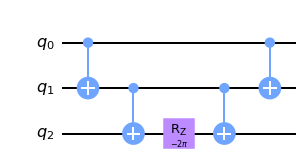

In [3]:
qc = QuantumCircuit(3)
sim_z(np.pi, qc, [0, 1, 2])
qc.draw('mpl')

Now, we can expand this so we can simulate any Pauli string.

In [4]:
def sim_pauli(arr, t, qc, qubits):
    """
    Append gates to simulate any Pauli string
    
    Parameters:
        arr: array
            Array encoding the Pauli string
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
    """
    new_arr = []
    new_qub = []
    for idx in range(len(arr)):
        if arr[idx] != 'I':
            new_arr.append(arr[idx])
            new_qub.append(qubits[idx])

    h_y = 1 / np.sqrt(2) * np.array([[1, -1j], [1j, -1]])
    for i in range(len(new_arr)):
        if new_arr[i] == 'X':
            qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            qc.unitary(h_y, [new_qub[i]], r'$H_y$')
            
    sim_z(t, qc, new_qub)
    
    for i in range(len(new_arr)):
        if new_arr[i] == 'X':
            qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            qc.unitary(h_y, [new_qub[i]], r'$H_y$')

And finally, we write a small function that takes in a Hamiltonian $\hat H$ as its Trotter decomposition and simulates it in a given quantum circuit. 

In [5]:
def sim_ham(hamiltonian, t, qc, qubits, trotter=1):
    """
    Simulates Hamiltonian given as Pauli string
    
    Parameters:
        hamiltonian: dict
            Dictionary encoding the hamiltonian with each
            Pauli product as a key with the coefficient as value
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
        
    """
    temp    = QuantumCircuit(len(qubits))
    delta_t = t / trotter
    for pauli in hamiltonian:
        sim_pauli(pauli, hamiltonian[pauli] * delta_t, temp, range(len(qubits)))
        
    for i in range(trotter):
        qc.compose(temp, qubits, inplace=True)

Analyzing this function, we can see that it basically resembles this formula that we introduced in the background:

$$ e^{i\hat Ht} \approx \big(\prod_k e^{i c_k P_k t/N }\big)^{N} $$

First, we see that `delta_t` corresponds to $t / N$. Then, for each Pauli term in the Pauli string representing the Hamiltonian (the first loop corresponds to the product $\prod_k$, since consecutive gates correspond to matrix multiplication), we call our function `sim_pauli` that adds the corresponding gates, using `time = hamiltonian[pauli] * delta_t`, which corresponds to $c_k t/n$ in the formula. Finally, we simply append the resulting circuit $N$ times in the second loop, which resembles the exponentiation.

**Comparing to exact calculation**

To wrap everything up, we can see how our simulation circuit compares to directly computing $e^{i \hat H t}|\psi\rangle$. Here, we test this with the Hamiltonian $\hat H = 2 XZY + 5 ZXX + 2 YXZ$, time $\frac{1}{2 * \pi}$ and $N = 50$, which gives us high accuracy. First, we will create the quantum circuit that simulates this and extract the resulting statevector.

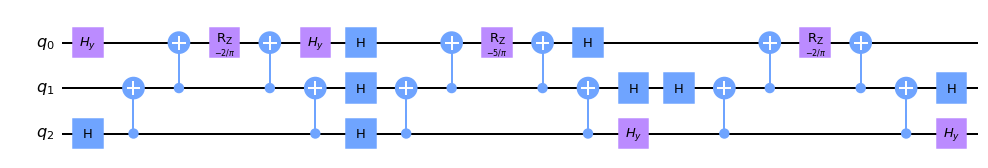

In [8]:
qc = QuantumCircuit(3)
sim_ham({"XZY": 2, "ZXX": 5, "YXZ": 2}, 1 / (2 * np.pi), qc, [0, 1, 2], trotter=1) 
qc = qc.reverse_bits() # reverse because of Qiskit's endianness
qc.draw('mpl')

For illustration purposes, the circuit above has $N=1$, but we will set it to $N=50$ when actually sending the circuit to the simulator.

In [23]:
from qiskit import Aer, execute
from sympy import Matrix

qc = QuantumCircuit(3)
sim_ham({"XZY": 2, "ZXX": 5, "YXZ": 2}, 1 / (2 * np.pi), qc, [0, 1, 2], trotter=50)
qc = qc.reverse_bits()

backend = Aer.get_backend('statevector_simulator')
result  = execute(qc, backend).result()
vec     = result.get_statevector()
vec     = vec / vec[0] # global phase
qvec    = vec / np.linalg.norm(vec) # normalize
Matrix(np.round(qvec, 5))

Matrix([
[             0.62069],
[                   0],
[                   0],
[  0.0279 + 0.66576*I],
[                   0],
[-0.26743 + 0.23046*I],
[-0.21432 + 0.01279*I],
[                   0]])

Note that here we used the `statevector_simulator` to directly extract the statevector. When using a real device, we would need to use state tomography (or a similar procedure) if we want to directly know the statevector. Now that we have our result with a quantum circuit, we can directly compute the expected result and compare. This is relatively simple, but a few comments are left in the following cell to clear any doubts.  

In [21]:
import scipy

# Start with |0> state
start    = np.zeros(2 ** 3)
start[0] = 1

# Get the matrix corresponding to some Pauli product
# This function can be optimized, but it is left as it
# is for clarity purposes
def get_pauli(string):
    init   = string[0]
    string = string[1:]
    if init == 'X':
        out = np.array([[0, 1], [1, 0]])
    elif init == 'Z':
        out = np.array([[1, 0], [0, -1]])
    elif init == 'Y':
        out = np.array([[0, -1j], [1j, 0]])
    else:
        out = np.eye(2)
    
    for p in string:
        if p == 'X':
            out = np.kron(out, np.array([[0, 1], [1, 0]]))
        elif p == 'Z':
            out = np.kron(out, np.array([[1, 0], [0, -1]]))
        elif p == 'Y':
            out = np.kron(out, np.array([[0, -1j], [1j, 0]]))
        else:
            out = np.kron(out, np.eye(2))

    return out

# Hamiltonian is calculated from the Pauli decomposition
decomp = {"XZY": 2, "ZXX": 5, "YXZ": 2}
H      = np.zeros((2 ** 3, 2 ** 3))
H      = H.astype('complex128')
for pauli in decomp:
    H += decomp[pauli] * get_pauli(pauli)
    
# Hamiltonian is exponentiated and we multiply the starting
# vector by it to get our result
simul  = scipy.linalg.expm(1j * H * (1 / (2 * np.pi)))
vec    = simul @ start
vec    = vec / vec[0] # global phase
cvec   = vec / np.linalg.norm(vec) # normalize
Matrix(np.round(cvec, 5))

Matrix([
[             0.62068],
[                   0],
[                   0],
[ 0.02652 + 0.66582*I],
[                   0],
[-0.26746 + 0.23046*I],
[-0.21449 + 0.00854*I],
[                   0]])

By simply comparing the two vectors, we can say that our simulation was pretty accurate! As a more mathematically rigorous comparison, we can use state fidelity, which also shows us that our simulation is pretty good!

In [24]:
from qiskit.quantum_info import state_fidelity

state_fidelity(qvec, cvec)

0.9999834345555811

**References**:
- [[1]](https://quantumcomputing.stackexchange.com/a/11373/16092) An approach for Hamiltonian simulation by Davit Khachatryan on Quantum Computing StackExchange.
- [[2]](https://quantumcomputing.stackexchange.com/a/8726/16092) Can arbitrary matrices be decomposed using the Pauli basis? by Danylo Y on Quantum Computing StackExchange.
- [[3]](https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441) Simulation of electronic structure Hamiltonians using quantum computers by James D. Whitfield ,Jacob Biamonte and Alán Aspuru-Guzik.